### Este projeto tem como foco a Classificação de amostras geológicas por meio de imagens por meio de imagens utilizando o modelo InceptionV3. O objetivo principal é avaliar a eficácia e precisão da rede neural pré-treinada na identificação de diferentes tipos de estruturas contidas em rochas. Esse estudo busca auxiliar profissionais no reconhecimento de estruturas geológicas assim como tambémfornecer conclusões relevantes sobre a aplicação de inteligência artificial em geologia e ciências da terra.

In [66]:
# Importações de libs necessárias

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image

In [67]:
# Definir caminhos dos diretórios de treino, validação e teste
diretorio_treino = 'D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Classes_Structures/Train/'
diretorio_validacao = 'D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Classes_Structures/Validation/'
diretorio_teste = 'D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Classes_Structures/Test/'

In [68]:
# Definir o tamanho das imagens e o número de classes
input_shape = (256, 256, 3)
num_classes = 9

In [69]:
# Definir os hiperparâmetros do treinamento
batch_size = 128
epochs = 100

##### Nesse passo será usado o 'ImageDataGenerator' que é uma classe da biblioteca Keras que permite gerar lotes de imagens aumentadas (augmented images) em tempo real durante o treinamento de modelos de aprendizado profundo.
##### O objetivo principal do 'ImageDataGenerator' é aumentar a quantidade de dados de treinamento disponíveis, melhorando a capacidade de generalização do modelo e reduzindo o risco de overfitting. O aumento de dados envolve a aplicação de transformações aleatórias nas imagens existentes, como rotação, translação, zoom, espelhamento horizontal, alteração de brilho, entre outras técnicas. 

In [70]:
# Definir o data augmentation para imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Usar o ImageDataGenerator normal (sem data augmentation) para imagens de validação e teste
validation_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)


In [71]:
# Definir o gerador de dados para as imagens de treinamento
train_generator = train_datagen.flow_from_directory(
    diretorio_treino,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    diretorio_validacao,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1310 images belonging to 9 classes.
Found 360 images belonging to 9 classes.
Found 135 images belonging to 9 classes.


In [72]:
# Carregar o modelo InceptionV3 pré-treinado, usando os pesos da Imagenet e informado o tamanho das imagens.
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas as camadas do modelo base
for layer in base_model.layers:
    layer.trainable = False

##### Foi adicionada uma camada de 1024 neurônios, diminuuindo até chegar próximo ao número de saída, todas Dense, e uma camada de saida Danse de 9 neurônios representando cada uma das classes de estruturas. Foi estabelecido um fator de aprendizagem de 0.001, bem como a função de reativação 'relu' no final de cada camada intermediária.  Foi usado o Dropout também, que é uma técnica eficaz para combater o overfitting, fornecendo uma regularização interna durante o treinamento da rede neural. E para finalizar  as camadas, foi usado a função de reativação 'softmax', pois esse estudo se trata de uma classificação multiclasse.

In [73]:
# Adicionar as suas camadas personalizadas no topo do modelomodel = Sequential()
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
tf.keras.layers.Dropout(0.35),
model.add(Dense(num_classes, activation='softmax'))

In [74]:
# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Exibir o resumo do modelo
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_30 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dense_33 (Dense)            (None, 128)               32896     
                                                      

In [75]:
# Criar o callback para visualização das imagens durante o treinamento
tensorboard_callback = TensorBoard(log_dir='./logs')

In [76]:
es = EarlyStopping(patience=4)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=4)
mc = ModelCheckpoint(filepath='best_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True) 

#### Após a configuração da rede, é possível realizar o treinamento utilizando o conjunto de dados de amostras geológicas. Durante o treinamento, é importante monitorar as métricas de desempenho da rede, como acurácia e perda. Para isto, foram usados os callbacks EarlyStopping e ReduceLROnPlateau para interromper o treinamento no momento de ter ganhos não significativos junto com o ModelCheckpoint que permite salvar o modelo com melhor eficiência.

In [77]:
# Treinar o modelo e armazenar o histórico
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
10/10 [==============================] - 13s 985ms/step - loss: 2.1375 - accuracy: 0.1953 - val_loss: 1.8326 - val_accuracy: 0.3516
Epoch 2/100
10/10 [==============================] - 8s 808ms/step - loss: 1.7033 - accuracy: 0.3689 - val_loss: 1.2650 - val_accuracy: 0.6133
Epoch 3/100
10/10 [==============================] - 8s 796ms/step - loss: 1.3987 - accuracy: 0.5169 - val_loss: 1.1632 - val_accuracy: 0.6289
Epoch 4/100
10/10 [==============================] - 8s 874ms/step - loss: 1.0952 - accuracy: 0.6286 - val_loss: 0.8802 - val_accuracy: 0.7305
Epoch 5/100
10/10 [==============================] - 9s 877ms/step - loss: 0.8872 - accuracy: 0.6945 - val_loss: 0.6917 - val_accuracy: 0.7773
Epoch 6/100
10/10 [==============================] - 8s 806ms/step - loss: 0.8760 - accuracy: 0.7081 - val_loss: 0.6291 - val_accuracy: 0.7930
Epoch 7/100
10/10 [==============================] - 9s 862ms/step - loss: 0.7746 - accuracy: 0.7281 - val_loss: 0.6197 - val_accuracy: 0.808

In [78]:
# Salvar o modelo Deep CNN
model.save('D:/Pessoal/Estudos_Pessoais/Pos_Graduacao/Clone_GitHub/Sprint_2/Deep_Learning/Geological_Structures/Models_Train/Inception_model5.h5')

In [79]:
# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Acurácia no conjunto de teste:', test_accuracy)

1/1 [==============================] - 0s 364ms/step - loss: 0.3701 - accuracy: 0.9141
Acurácia no conjunto de teste: 0.9140625


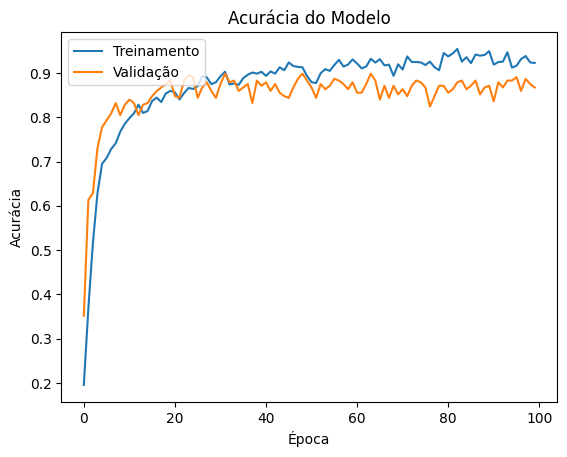

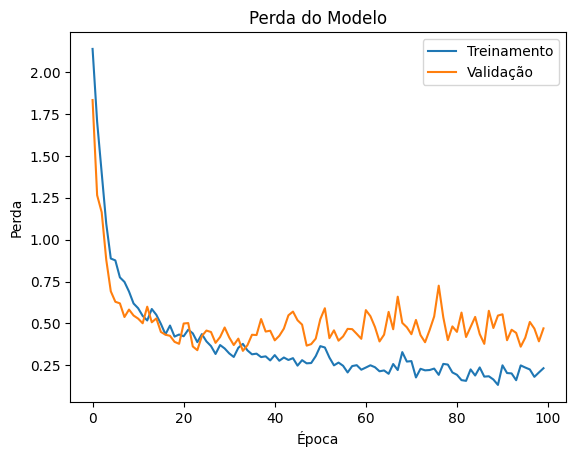

In [80]:
# Plotar a acurácia e a perda durante o treinamento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(['Treinamento', 'Validação'], loc='upper right')
plt.show()

4/4 [==============================] - 1s 50ms/step


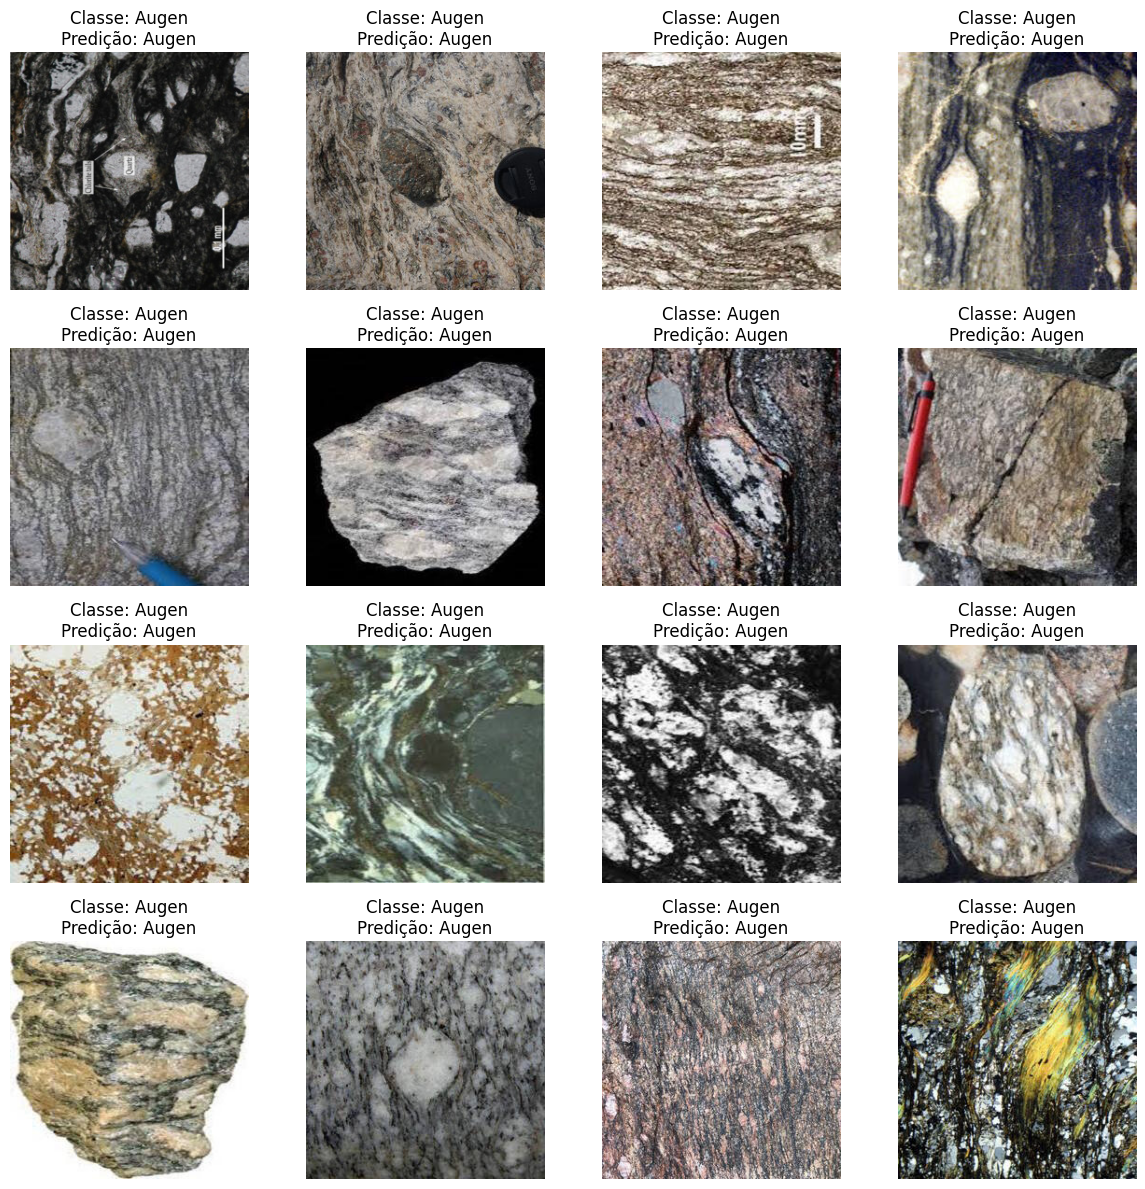

In [81]:
# Visualizar algumas imagens do conjunto de validação e suas classes
class_names = sorted(validation_generator.class_indices.keys())
images, labels = next(validation_generator)
predicted_labels = model.predict(images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = images[i]
    label = np.argmax(labels[i])
    predicted_label = np.argmax(predicted_labels[i])
    
    ax.imshow(img)
    ax.set_title(f'Classe: {class_names[label]}\nPredição: {class_names[predicted_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [82]:
# Fazer previsões nas imagens de teste
predictions = model.predict(test_generator)

2/2 [==============================] - 1s 304ms/step


In [83]:
# Obter as classes preditas para cada imagem
predicted_classes = np.argmax(predictions, axis=1)

In [84]:
# Obter as classes reais para cada imagem
true_classes = test_generator.classes

In [85]:
# Obter os rótulos das classes
class_labels = list(test_generator.class_indices.keys())

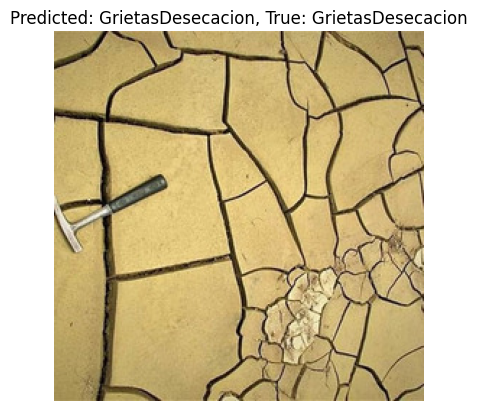

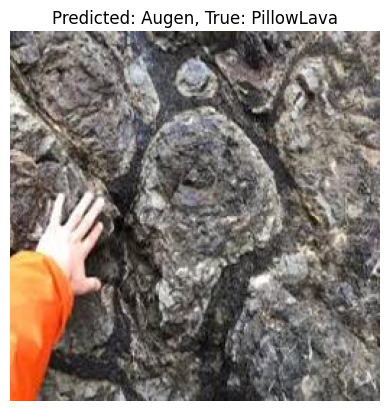

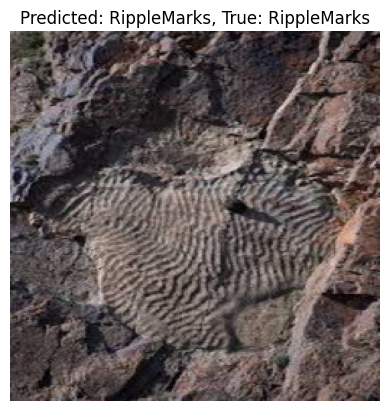

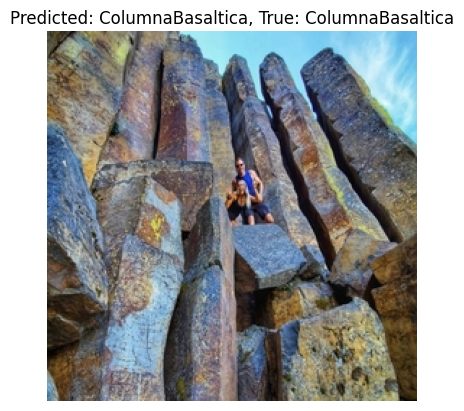

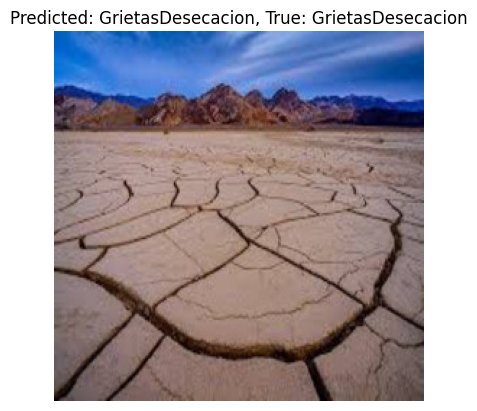

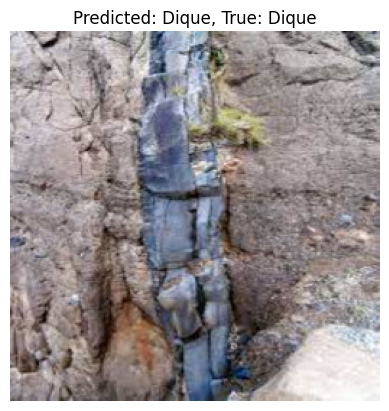

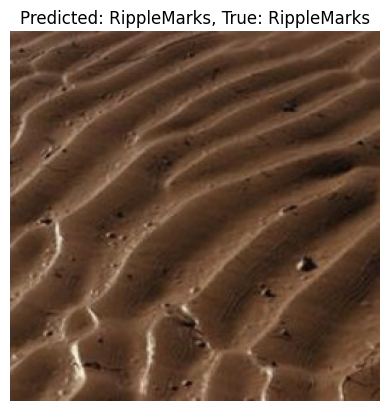

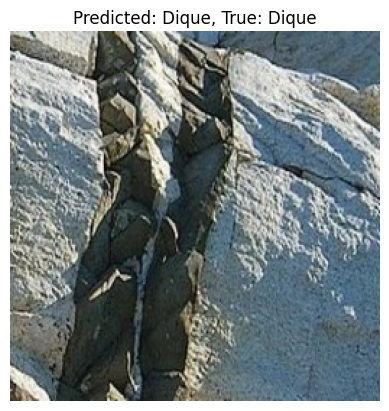

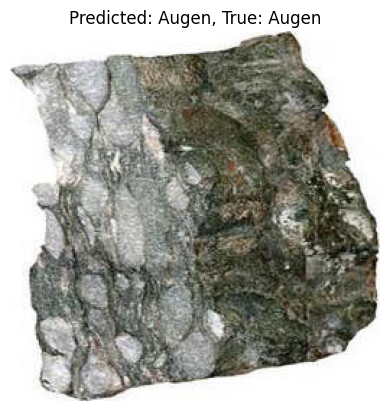

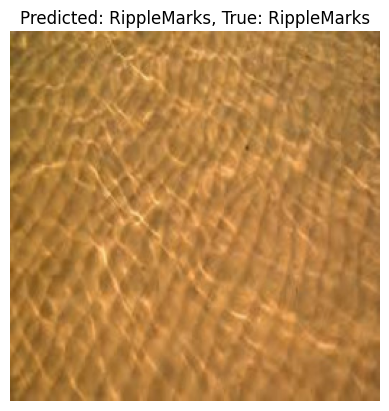

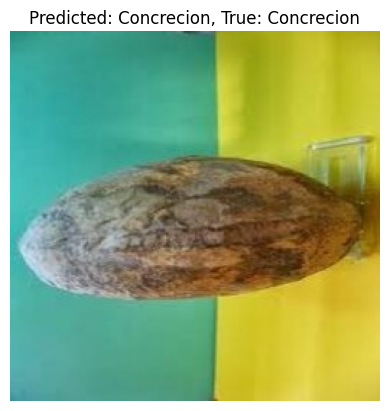

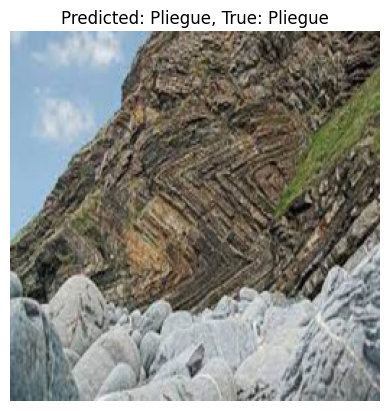

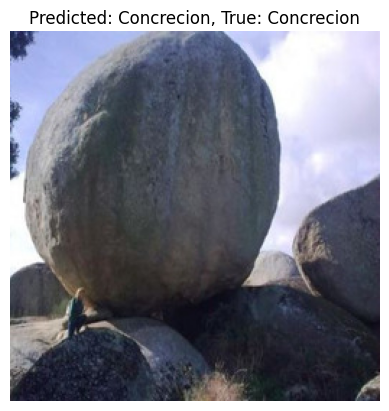

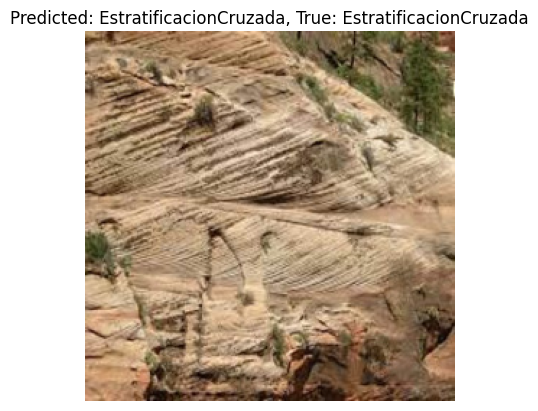

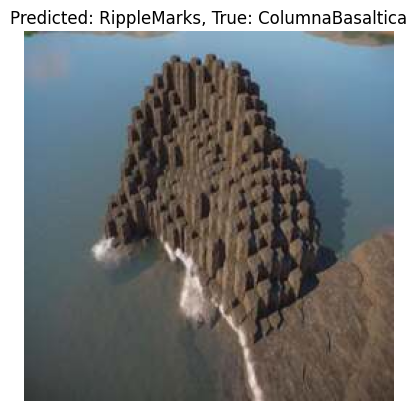

In [86]:
# Mostrar algumas imagens de teste com suas classes preditas e reais
num_images = 15  # Número de imagens para mostrar
sample_indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)
for idx in sample_indices:
    image_path = os.path.join(diretorio_teste, test_generator.filenames[idx])
    image = Image.open(image_path)
    predicted_class = class_labels[predicted_classes[idx]]
    true_class = class_labels[true_classes[idx]]
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')
    plt.show()